Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.5WS41C_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Model loaded successfully!
Training samples: 1164
Validation samples: 291
Epoch 1/3
   1164/Unknown 305s 252ms/step - accuracy: 0.9522 - loss: 0.1292

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1164/1164 ━━━━━━━━━━━━━━━━━━━━ 380s 317ms/step - accuracy: 0.9522 - loss: 0.1291 - val_accuracy: 0.9893 - val_loss: 0.0324
Epoch 2/3
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 442s 373ms/step - accuracy: 0.9869 - loss: 0.0372 - val_accuracy: 0.9903 - val_loss: 0.0316
Epoch 3/3
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 465s 341ms/step - accuracy: 0.9905 - loss: 0.0265 - val_accuracy: 0.9908 - val_loss: 0.0300


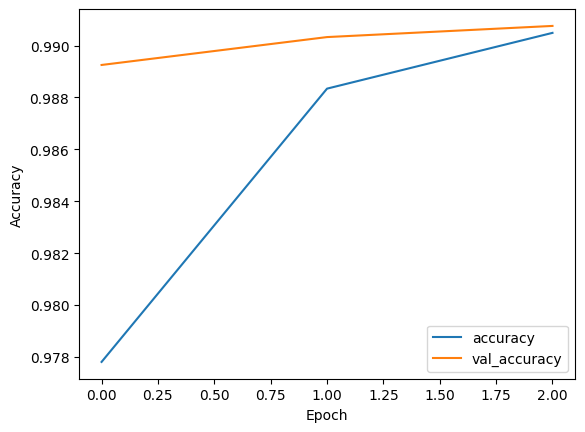

291/291 ━━━━━━━━━━━━━━━━━━━━ 76s 262ms/step - accuracy: 0.9916 - loss: 0.0283
Test Accuracy: 0.9907566905021667


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# Load Cats vs. Dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True
)

# Preprocess function
def format_image(image, label):
    try:
        image = tf.image.resize(image, (224, 224)) / 255.0
        return image, label
    except Exception as e:
        print("Skipping corrupted image.", e)
        return tf.zeros((224, 224, 3)), -1  # Return dummy image-label

# Filter out dummy labels
def filter_valid(image, label):
    return tf.not_equal(label, -1)

ds_train = ds_train.map(format_image).filter(filter_valid).batch(16).shuffle(500)
ds_test = ds_test.map(format_image).filter(filter_valid).batch(16)

# Ensure cache directory exists
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_modules"

# Use a stable MobileNetV2 feature extractor
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    input_shape=(224, 224, 3),
    trainable=False  # Freeze base model
)

print("Model loaded successfully!")

# Build Model using Functional API
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda img: base_model(img))(inputs)  # Ensure training=False for frozen layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary classification (Cats vs. Dogs)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),  # Lower LR for fine-tuning
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

print(f'Training samples: {sum(1 for _ in ds_train)}')
print(f'Validation samples: {sum(1 for _ in ds_test)}')

# Train the model
history = model.fit(ds_train, epochs=3, validation_data=ds_test)

# Plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test)
print("Test Accuracy:", test_acc)
